In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [3]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [5]:
df_ibis = pd.read_csv('../../../data/processed/cleaned_ibis-sg-bencoolen.csv')
df_boss = pd.read_csv('../../../data/processed/cleaned_hotel-boss.csv')
df_g = pd.read_csv('../../../data/processed/cleaned_hotel-G.csv')
df_village = pd.read_csv('../../../data/processed/cleaned_village-hotel-albert-court-by-far-east-hospitality.csv')
df_holiday = pd.read_csv('../../../data/processed/cleaned_holiday-inn-express-clarke-quay.csv')


df_combi = pd.concat([df_ibis, df_boss, df_g, df_village, df_holiday])

In [33]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['year'] >= 2015]

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.extend(['ibis', 'boss', 'village', 'ibis_bencoolen', 'bencoolen', 'albert', 'far_east', 'east_hospitality',
           'clarke', 'quay', 'express', 'clarke_quay', 'albert_court', 'court', 'clark', 'inn', 'marina'])

stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stem Review

In [34]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [35]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_filtered['stem_tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [ ]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_filtered['stem_tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

In [36]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [37]:
# For Pre-COVID
topics_pre_stem = ldamodel.show_topics(formatted=False, num_words=20)
data_flat_pre = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_8248\1556627539.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


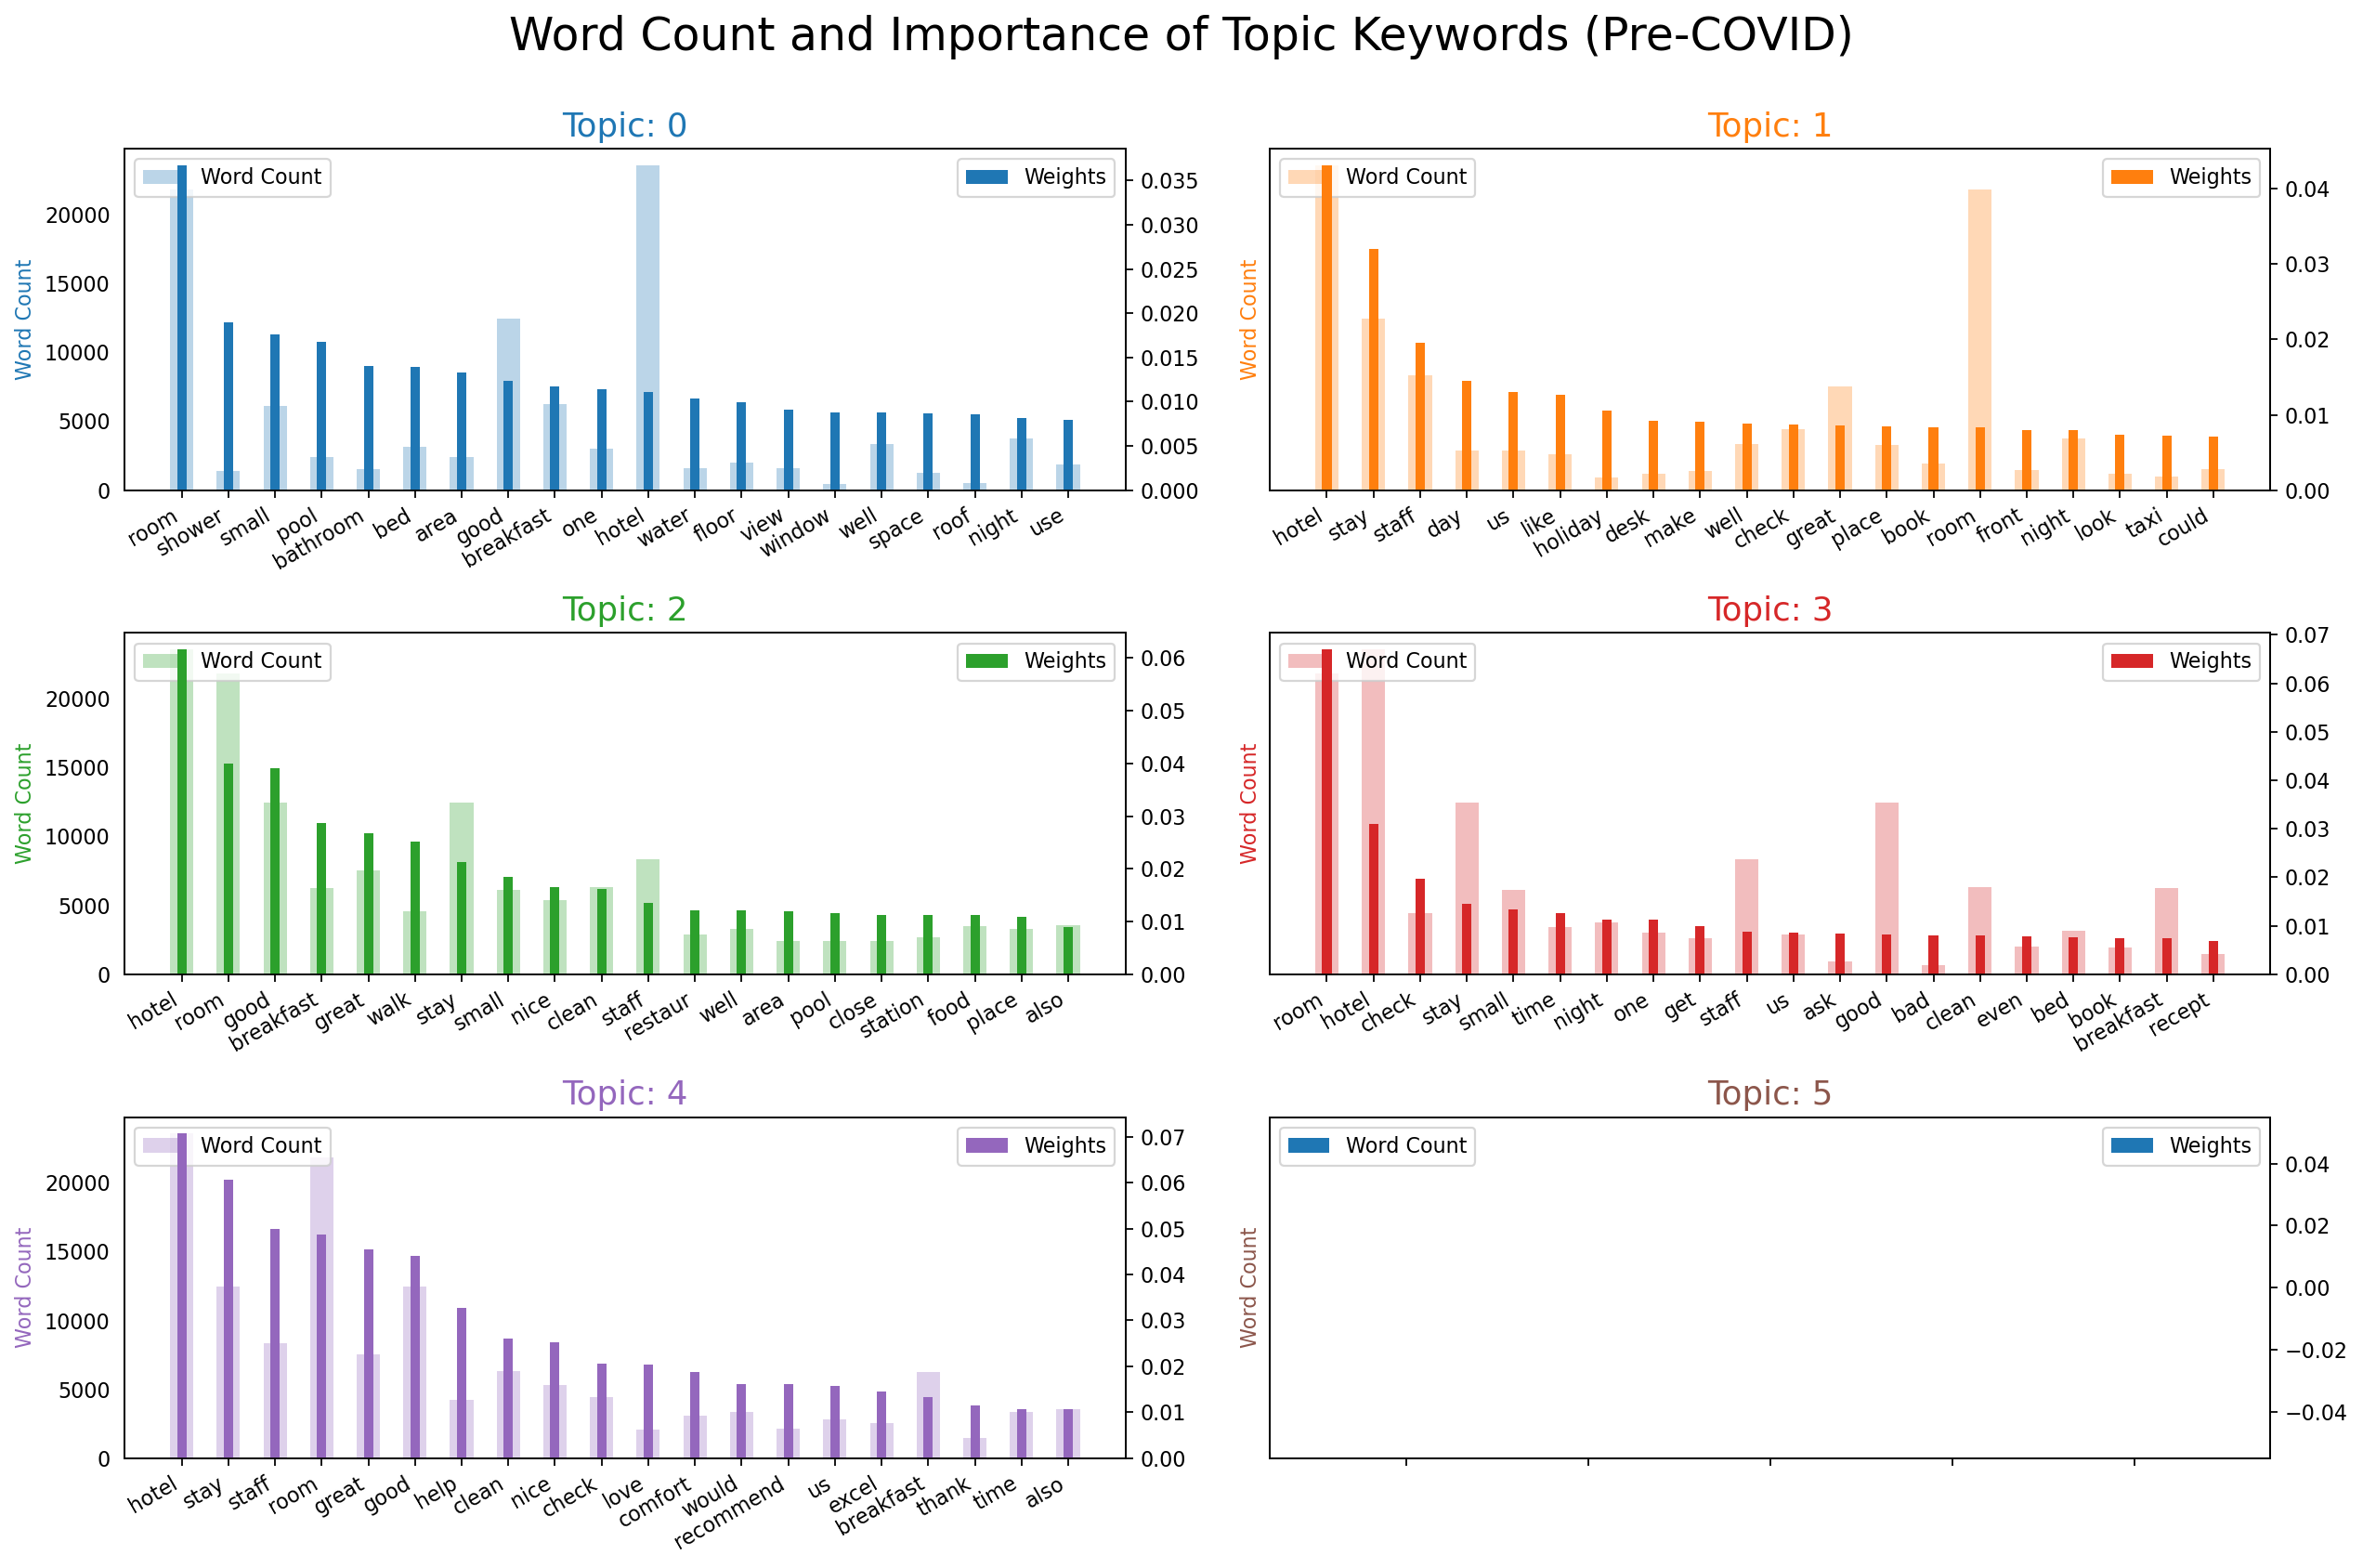

In [38]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre_stem, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

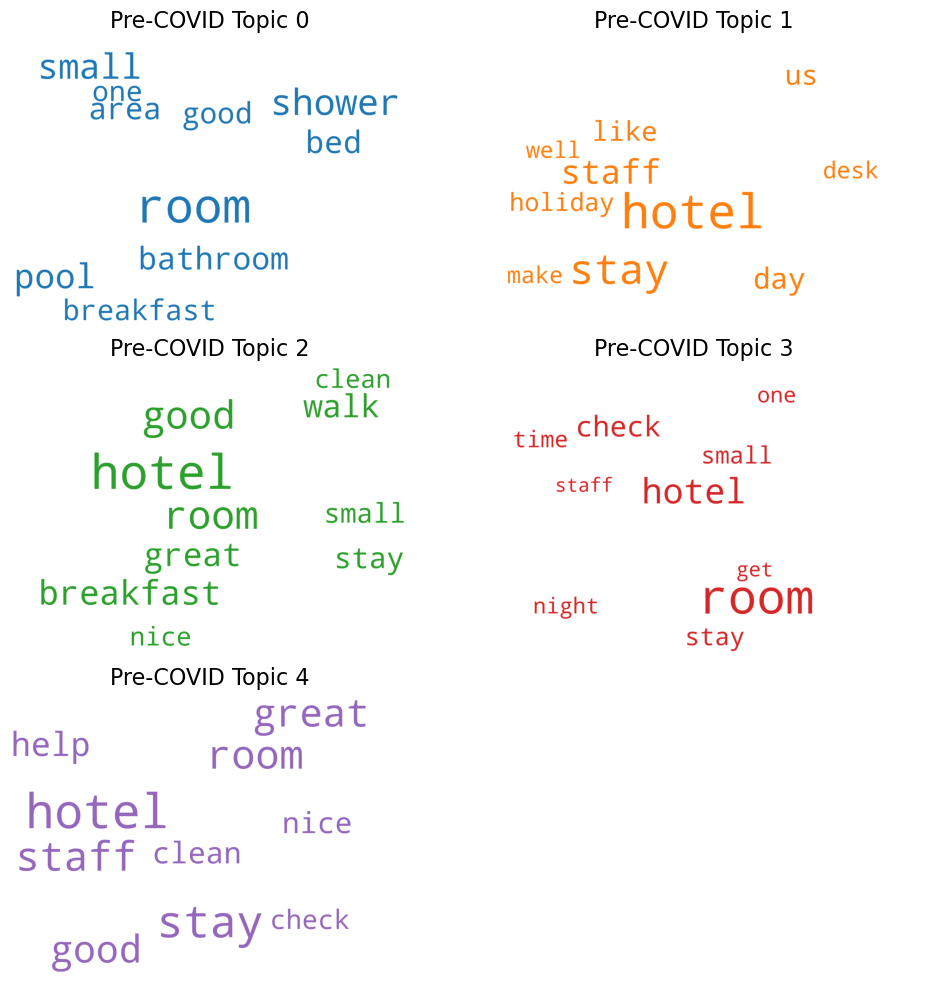

In [39]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [40]:
vis = pyLDAvis.gensim.prepare(topic_model=ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [56]:
clean_data = df_filtered['stem_review'].apply(preprocess)
clean_data = clean_data.apply(lambda x: ' '.join(x))

In [57]:
from nltk import ngrams
bigrams_data = []

for d in clean_data:
    tokens = word_tokenize(d)
    bigrams_data.append(["_".join(w) for w in ngrams(tokens, 2)])


In [58]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_data)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_data]

lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=5, id2word=pre_dict, passes=15)

In [59]:
# For Pre-COVID
topics_pre_stembi = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_data for word in word_list]

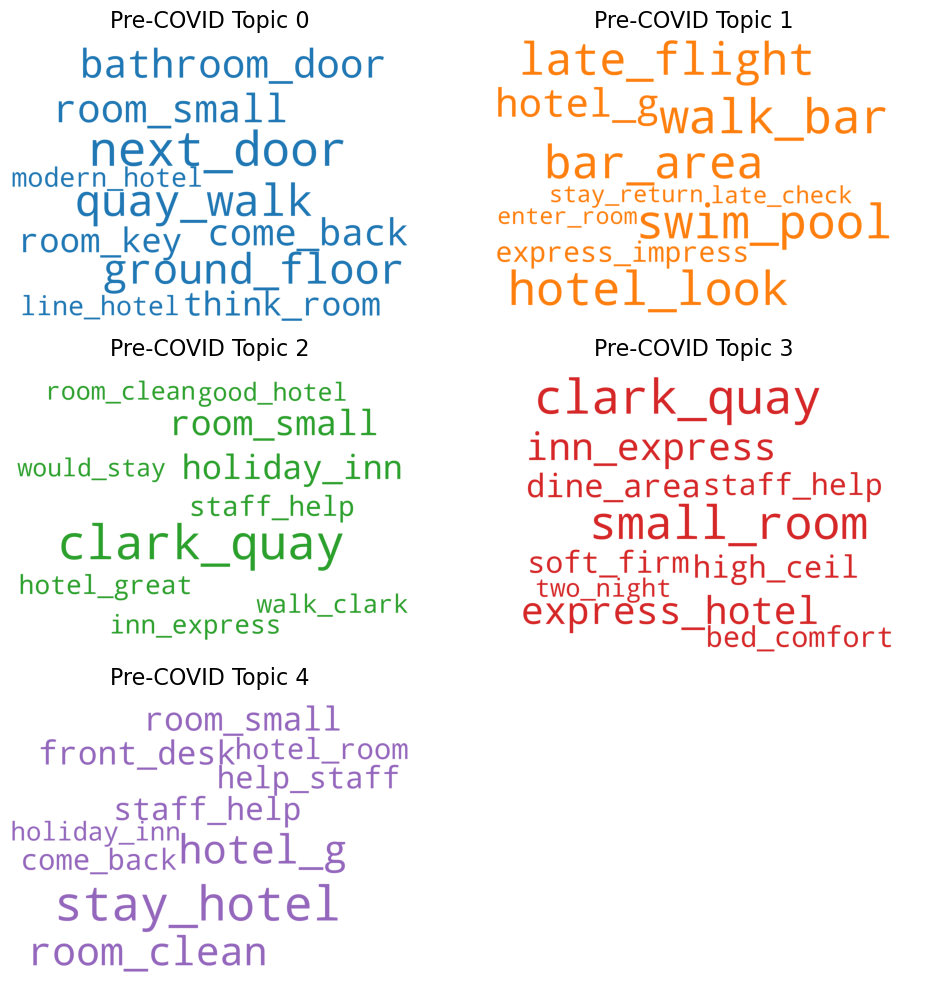

In [60]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [61]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [62]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [63]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(df_filtered['lem_tokens'])
pre_corpus = [pre_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [64]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    pre_ldamodel = lda(pre_corpus, num_topics=i, id2word=pre_dict, passes=15)
    
    precovid_coherence = CoherenceModel(model=pre_ldamodel, texts=df_filtered['lem_tokens'], dictionary=pre_dict, coherence='c_v')
    lda_coherence = precovid_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.37901132660635456
The coherence score at topic 3 is 0.39874886224885236
The coherence score at topic 4 is 0.39508632740739436
The coherence score at topic 5 is 0.37479238963675254
The coherence score at topic 6 is 0.39786571593180237


In [66]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=3, id2word=pre_dict, passes=15)

In [67]:
# For All
topics_pre_lem = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_15000\478201950.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')


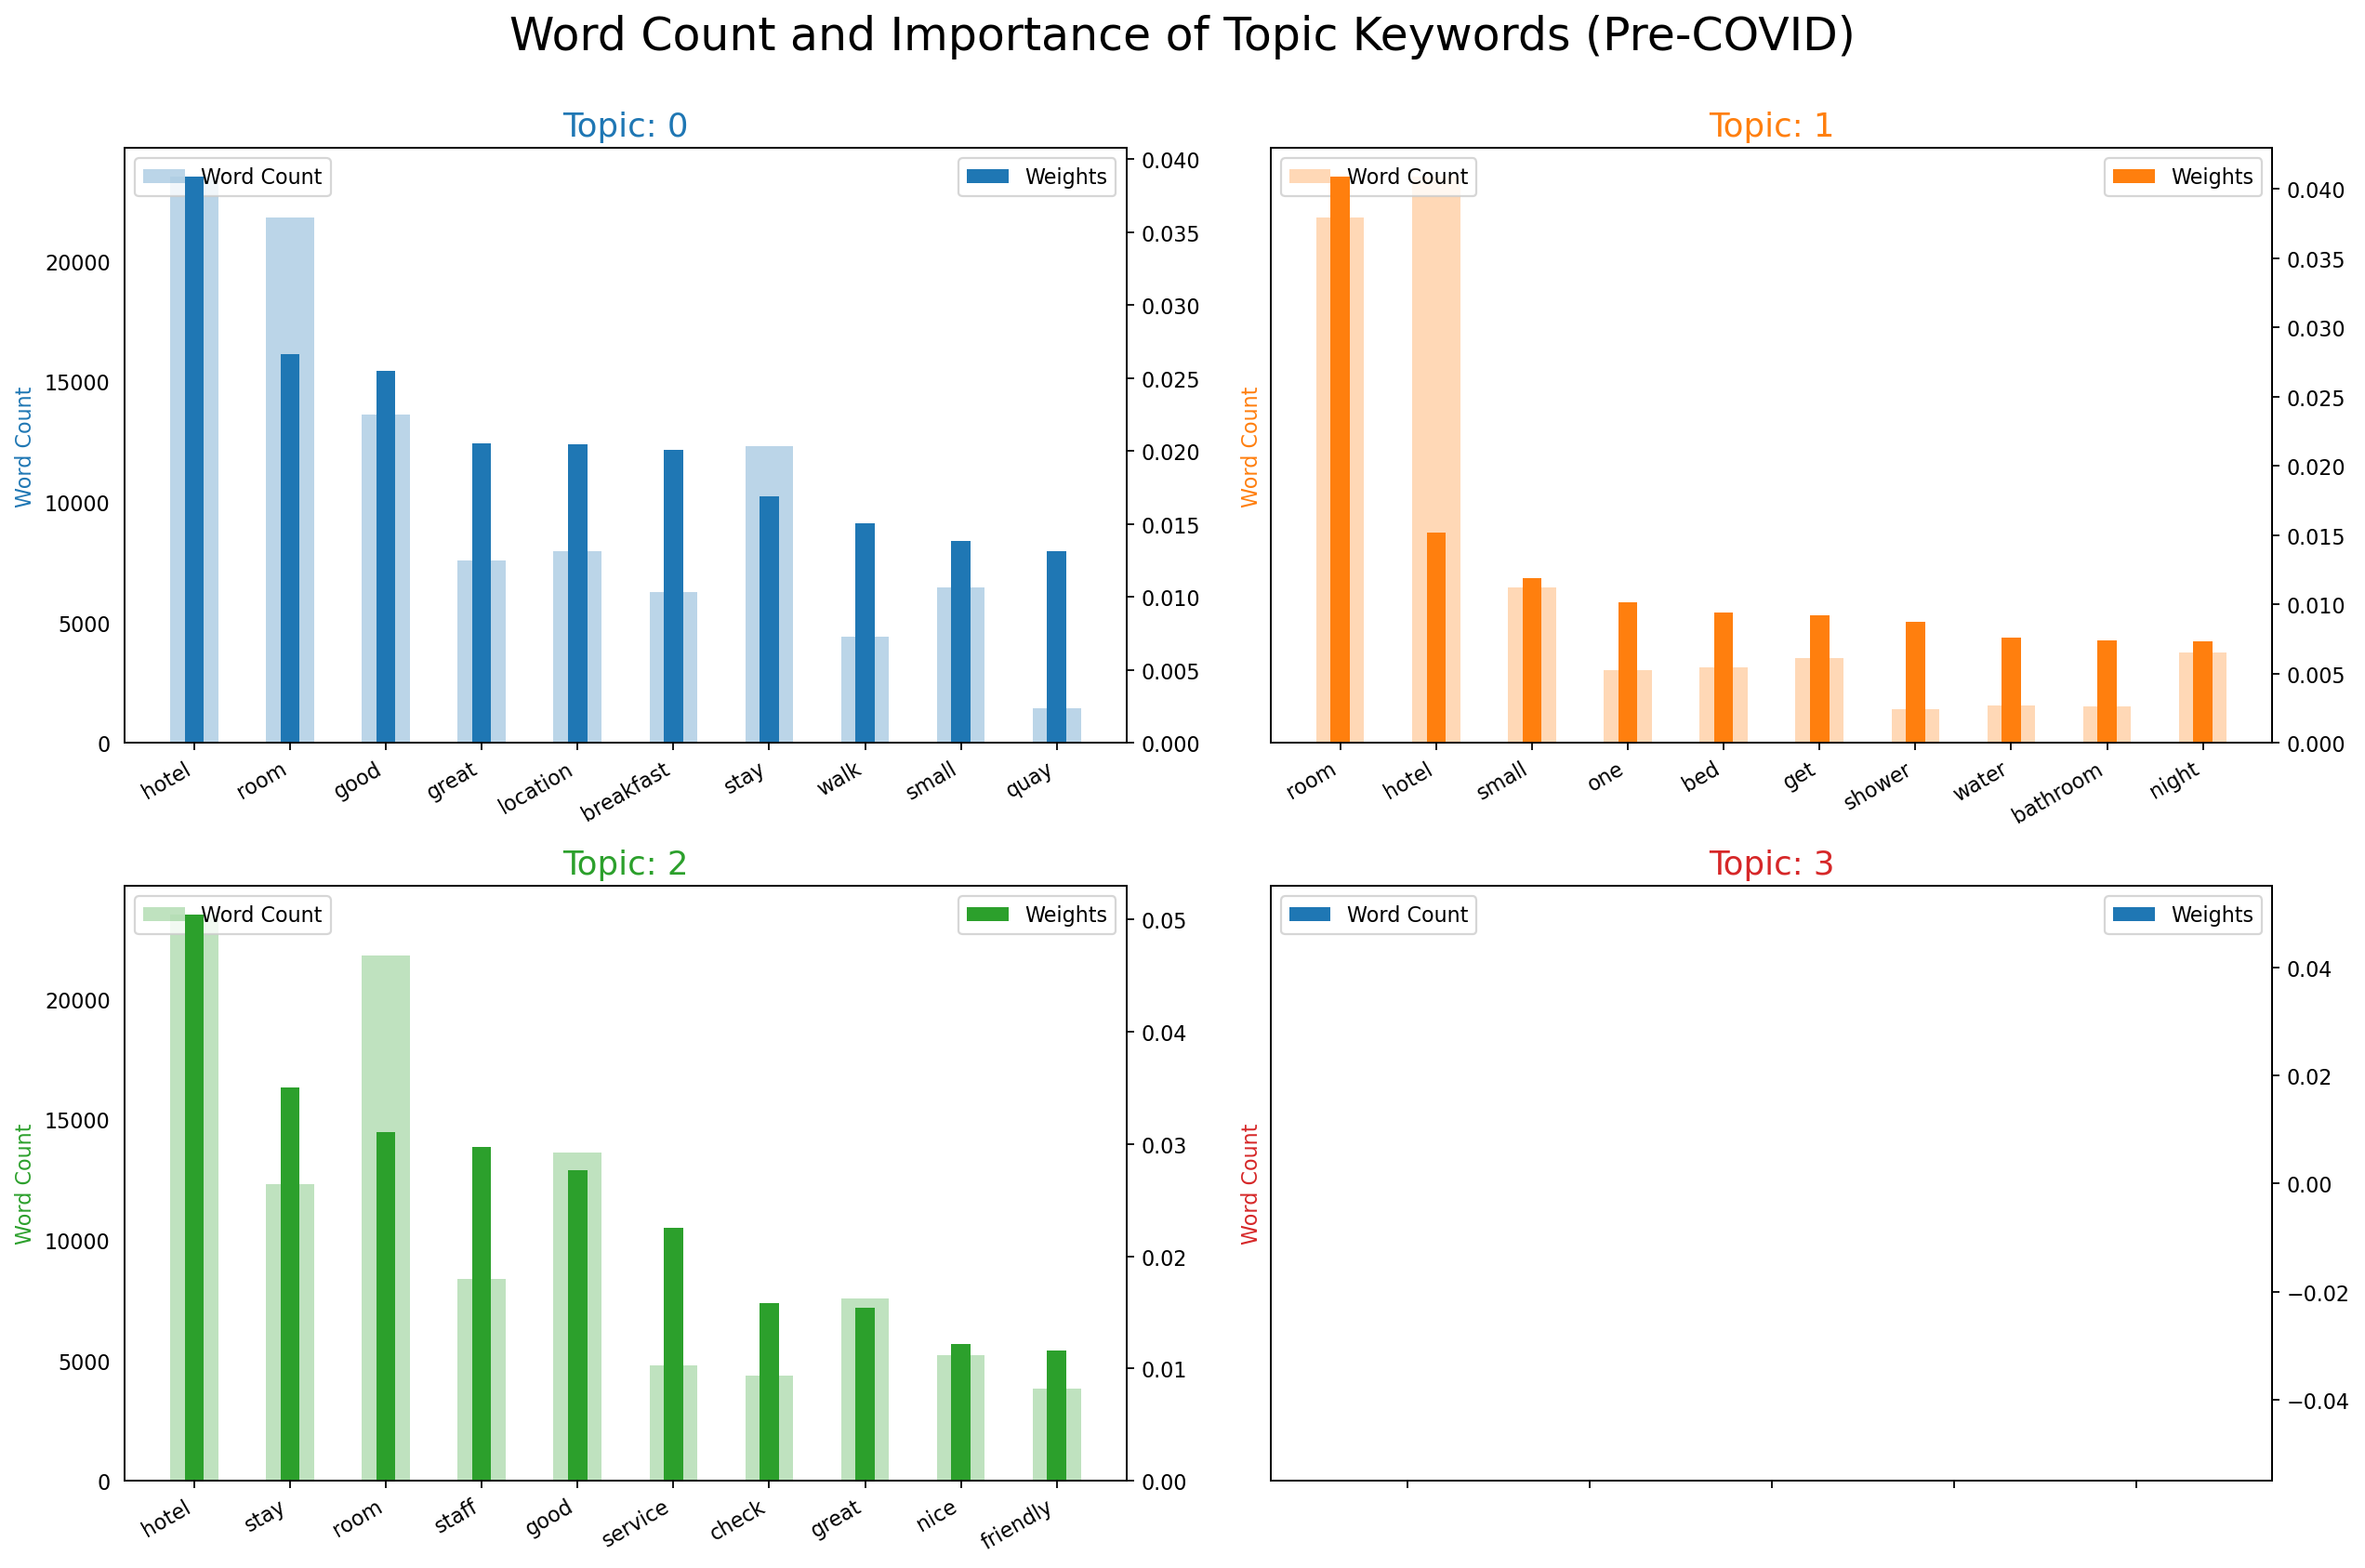

In [69]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_pre_lem, data_flat_pre, 'Word Count and Importance of Topic Keywords (Pre-COVID)')

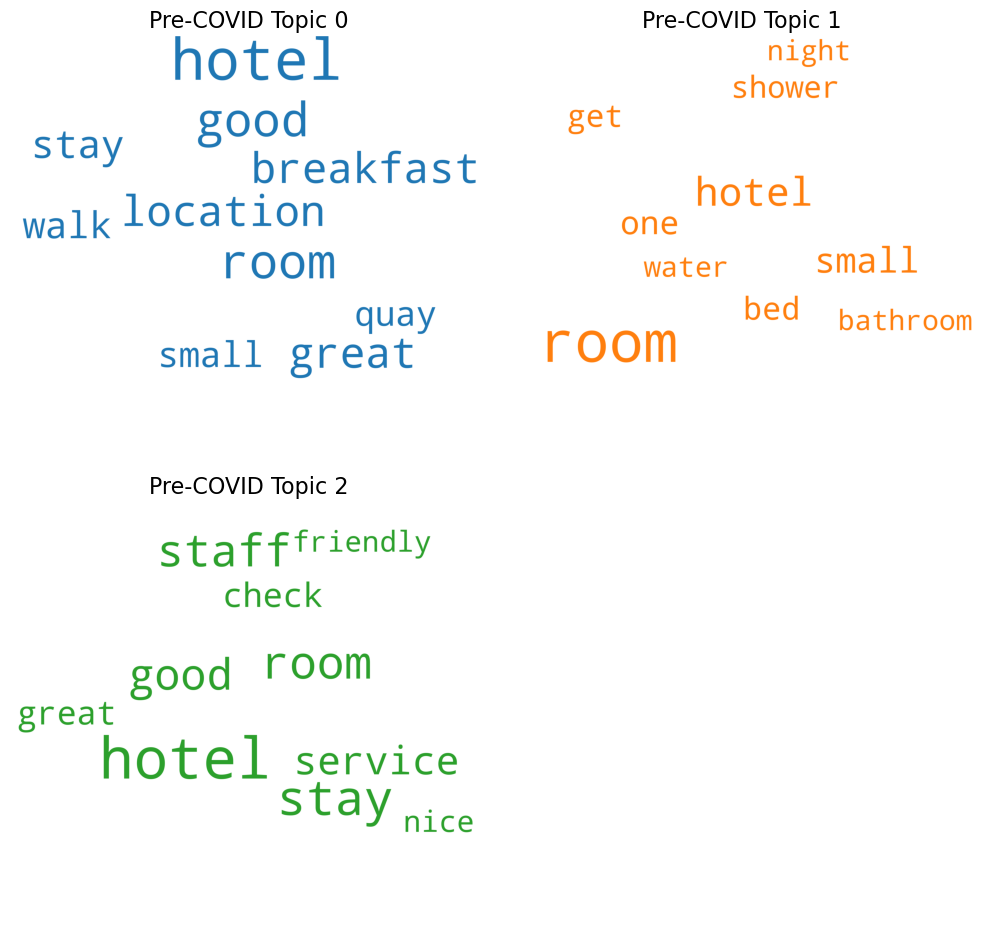

In [70]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [71]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Bigrams

In [72]:
clean_data = df_filtered['lem_review'].apply(preprocess)
clean_data = clean_data.apply(lambda x: ' '.join(x))

In [73]:
from nltk import ngrams
bigrams_data = []

for d in clean_data:
    tokens = word_tokenize(d)
    bigrams_data.append(["_".join(w) for w in ngrams(tokens, 2)])


In [76]:
##Generate LDA dictionary and corpus
pre_dict = corpora.Dictionary(bigrams_data)
pre_corpus = [pre_dict.doc2bow(text) for text in bigrams_data]

lda = gensim.models.ldamodel.LdaModel
pre_ldamodel = lda(pre_corpus, num_topics=3, id2word=pre_dict, passes=15)

In [77]:
# For Pre-COVID
topics_pre_lembi = pre_ldamodel.show_topics(formatted=False)
data_flat_pre = [word for word_list in bigrams_data for word in word_list]

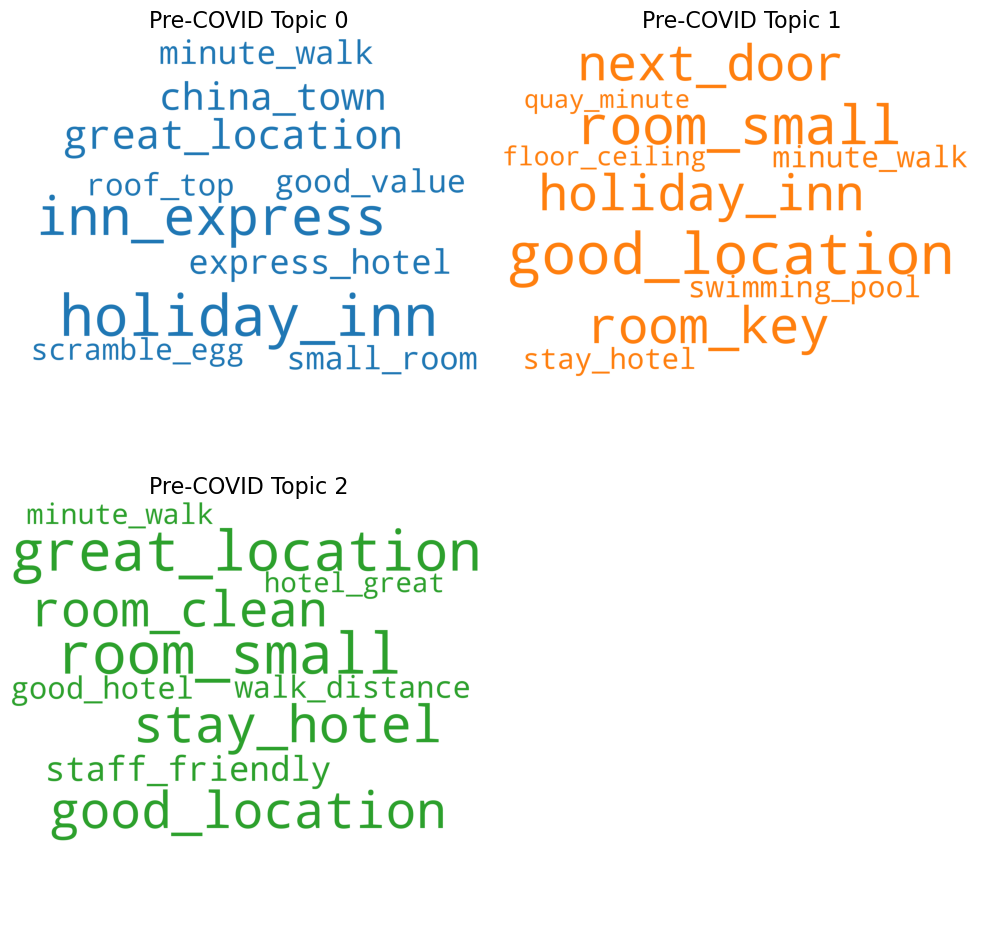

In [78]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(pre_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Pre-COVID Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [79]:
vis = pyLDAvis.gensim.prepare(topic_model=pre_ldamodel, corpus=pre_corpus, dictionary=pre_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Topic Extraction

In [41]:
topics_pre_stem

[(0,
  [('room', 0.036738228),
   ('shower', 0.018920882),
   ('small', 0.017575512),
   ('pool', 0.016795445),
   ('bathroom', 0.01401923),
   ('bed', 0.013931931),
   ('area', 0.013253624),
   ('good', 0.012396147),
   ('breakfast', 0.011763909),
   ('one', 0.0114282295),
   ('hotel', 0.011045688),
   ('water', 0.010390527),
   ('floor', 0.009988063),
   ('view', 0.00905226),
   ('window', 0.0088072885),
   ('well', 0.008738007),
   ('space', 0.008719858),
   ('roof', 0.008614655),
   ('night', 0.008128009),
   ('use', 0.007907759)]),
 (1,
  [('hotel', 0.043142676),
   ('stay', 0.032061625),
   ('staff', 0.019550154),
   ('day', 0.014533021),
   ('us', 0.012975507),
   ('like', 0.012673214),
   ('holiday', 0.010576707),
   ('desk', 0.009257223),
   ('make', 0.009139571),
   ('well', 0.008800095),
   ('check', 0.008704637),
   ('great', 0.008620071),
   ('place', 0.008462926),
   ('book', 0.008399544),
   ('room', 0.008382529),
   ('front', 0.007982908),
   ('night', 0.007943352),
   

In [42]:
top_dict = {}
for i in topics_pre_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        top_dict[i[0]].append(j[0])

In [43]:
top_dict

{0: ['room',
  'shower',
  'small',
  'pool',
  'bathroom',
  'bed',
  'area',
  'good',
  'breakfast',
  'one',
  'hotel',
  'water',
  'floor',
  'view',
  'window',
  'well',
  'space',
  'roof',
  'night',
  'use'],
 1: ['hotel',
  'stay',
  'staff',
  'day',
  'us',
  'like',
  'holiday',
  'desk',
  'make',
  'well',
  'check',
  'great',
  'place',
  'book',
  'room',
  'front',
  'night',
  'look',
  'taxi',
  'could'],
 2: ['hotel',
  'room',
  'good',
  'breakfast',
  'great',
  'walk',
  'stay',
  'small',
  'nice',
  'clean',
  'staff',
  'restaur',
  'well',
  'area',
  'pool',
  'close',
  'station',
  'food',
  'place',
  'also'],
 3: ['room',
  'hotel',
  'check',
  'stay',
  'small',
  'time',
  'night',
  'one',
  'get',
  'staff',
  'us',
  'ask',
  'good',
  'bad',
  'clean',
  'even',
  'bed',
  'book',
  'breakfast',
  'recept'],
 4: ['hotel',
  'stay',
  'staff',
  'room',
  'great',
  'good',
  'help',
  'clean',
  'nice',
  'check',
  'love',
  'comfort',
  'wo

In [44]:
df_res = pd.DataFrame(top_dict)
df_res

0        1          2          3          4
0        room    hotel      hotel       room      hotel
1      shower     stay       room      hotel       stay
2       small    staff       good      check      staff
3        pool      day  breakfast       stay       room
4    bathroom       us      great      small      great
5         bed     like       walk       time       good
6        area  holiday       stay      night       help
7        good     desk      small        one      clean
8   breakfast     make       nice        get       nice
9         one     well      clean      staff      check
10      hotel    check      staff         us       love
11      water    great    restaur        ask    comfort
12      floor    place       well       good      would
13       view     book       area        bad  recommend
14     window     room       pool      clean         us
15       well    front      close       even      excel
16      space    night    station        bed  breakfast
17       roof     look       food       book      thank
18      night     taxi      place  breakfast       time
19        use    could       also     recept       also

In [36]:
df_res.to_csv('3-star LDA.csv')

## DP

In [19]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [20]:
# Pass in LDA topics output to remove overlap words by choosing highest prob
def restruct_topics(topics): 
    word_prob_dict = {}
    for i in range(len(topics)):
        topic_num = topics[i][0]
        for word, prob in topics[i][1]:
            if word in word_prob_dict:
                word_prob_dict[word].append((topic_num, prob))
            else:
                ls = [(topic_num, prob)]
                word_prob_dict[word] = ls
    new_dict = {}
    for word in word_prob_dict:
        topic, highest_prob = max(word_prob_dict[word], key = lambda x: x[1])
        if topic in new_dict:
            new_dict[topic].append(word)
        else:
            ls = [word]
            new_dict[topic] = ls
    return new_dict

In [21]:
new_dict = restruct_topics(topics_pre_stem)

In [22]:
new_dict = restruct_topics(topics_pre_stem)
for x in new_dict:
    print(f'length topic {x}: {len(new_dict[x])}')

length topic 0: 14
length topic 4: 14
length topic 3: 12
length topic 2: 13
length topic 1: 9


In [23]:
#takes in the dataframe and appends to each row (aspect, review) pair(s)
def dep_parse(data, new_dict):
    data['aspect_sentiment'] = np.empty((len(data), 0)).tolist()
    for i in range(len(data)):
        sentence = data['combined_review'][i]
        doc = nlp(sentence)
        aspect_sentiment = []
        for word in doc:
            cond = False
            for x in new_dict.values():
                if word.text in x:
                    cond = True
                    break
            if not cond:
                continue
            if word.pos_ == 'NOUN': 
                for j in word.lefts:
                    #print(j, word, j.dep_, j.pos_)
                    if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                        tup = [word, j, list(new_dict.values()).index(x)]
                        #print(tup)
                        aspect_sentiment.append(tup)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':
                            #print(word, j ,k)
                            tup = (word, k.text + ' ' + j.text)
                            aspect_sentiment.append(tup)
                            if (word, j) in aspect_sentiment:
                                aspect_sentiment.remove([word, j, list(new_dict.values()).index(x)])
        data['aspect_sentiment'][i] = aspect_sentiment

In [24]:
df_filtered = df_filtered.reset_index()

In [25]:
dep_parse(df_filtered, new_dict)

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aspect_sentiment'][i] = aspect_sentiment
C:\Users\Chen Wei\AppData\Local\Temp\ipykernel_416\1416447991.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [26]:
df_filtered['aspect_sentiment']

0        [[hotel, decent, 0], [room, compact, 2], [bath...
1        [[hotel, Good, 0], [place, great, 0], [hotel, ...
2                     [[place, Good, 0], [place, Good, 0]]
3        [[staff, great, 0], [hotel, neat, 0], [door, n...
4                       [[door, next, 4], [time, long, 0]]
                               ...                        
14065                                                   []
14066                                                   []
14067                [[hotel, Good, 0], [room, actual, 2]]
14068                                [[room, adjacent, 2]]
14069                                    [[time, next, 0]]
Name: aspect_sentiment, Length: 14070, dtype: object

## Import PyABSA

In [45]:
df_test = pd.read_json('../pyABSA_outputs/Aspect_Term_Extraction_and_Polarity_Classification_FAST_LCF_ATEPC.json')

In [46]:
df_test

sentence  \
0      clean comfort hotel room find decent hotel tra...   
1      good hotel great great place great room small ...   
2      good place decent price good place good price ...   
3      great great staff neat hotel line star rate st...   
4      good budget stay stay day nice seven eleven ne...   
...                                                  ...   
68287  swiss hotel swiss stay hotel mani time recent ...   
68288  stay stay night wife ideal view th floor floor...   
68289  great view great decent room one night hotel v...   
68290  hotel date old four night mani cup machin shop...   
68291  poor hotel book hotel brother oversea come spe...   

                                                     IOB  \
0      [O, B-ASP, O, O, O, O, O, O, O, B-ASP, O, O, O...   
1      [O, O, O, O, B-ASP, O, O, O, O, O, O, O, O, O,...   
2      [O, O, O, B-ASP, O, O, O, O, O, O, O, O, B-ASP...   
3      [O, O, B-ASP, O, O, O, O, O, O, B-ASP, I-ASP, ...   
4      [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
...                                                  ...   
68287  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
68288  [O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, O,...   
68289  [O, B-ASP, O, O, B-ASP, O, O, O, O, O, O, O, O...   
68290  [O, O, O, O, O, O, O, O, O, O, O, O, O, B-ASP,...   
68291  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   

                                                  tokens  \
0      [clean, comfort, hotel, room, find, decent, ho...   
1      [good, hotel, great, great, place, great, room...   
2      [good, place, decent, price, good, place, good...   
3      [great, great, staff, neat, hotel, line, star,...   
4      [good, budget, stay, stay, day, nice, seven, e...   
...                                                  ...   
68287  [swiss, hotel, swiss, stay, hotel, mani, time,...   
68288  [stay, stay, night, wife, ideal, view, th, flo...   
68289  [great, view, great, decent, room, one, night,...   
68290  [hotel, date, old, four, night, mani, cup, mac...   
68291  [poor, hotel, book, hotel, brother, oversea, c...   

                                           aspect  \
0      [comfort, food, glass, closet space, port]   
1                                         [place]   
2                                   [price, food]   
3                             [staff, front desk]   
4                                          [wait]   
...                                           ...   
68287                 [size, staff, porter, crew]   
68288                          [view, staff, air]   
68289                      [view, room, bathroom]   
68290                                [bed, cover]   
68291                         [floor, fruit, key]   

                               position  \
0      [[1], [9], [30], [37, 38], [47]]   
1                                 [[4]]   
2                           [[3], [12]]   
3                        [[2], [9, 10]]   
4                                [[18]]   
...                                 ...   
68287          [[15], [35], [67], [78]]   
68288                 [[5], [25], [45]]   
68289                  [[1], [4], [23]]   
68290                      [[13], [18]]   
68291                [[26], [31], [39]]   

                                               sentiment  \
0      [Positive, Negative, Negative, Negative, Negat...   
1                                             [Positive]   
2                                   [Positive, Negative]   
3                                   [Positive, Positive]   
4                                             [Positive]   
...                                                  ...   
68287           [Negative, Negative, Negative, Negative]   
68288                     [Positive, Positive, Positive]   
68289                     [Positive, Positive, Positive]   
68290                               [Positive, Positive]   
68291                     [Negative, Negative, Negative]   

          

In [56]:
df_json = df_test[df_test['sentence'].isin(list(df_filtered['stem_review']))]

In [57]:
df_json = df_json[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]

In [58]:
df_json

sentence  \
0      clean comfort hotel room find decent hotel tra...   
1      good hotel great great place great room small ...   
2      good place decent price good place good price ...   
3      great great staff neat hotel line star rate st...   
4      good budget stay stay day nice seven eleven ne...   
...                                                  ...   
14065  small enough stay close station swim pool smal...   
14066  great visit recent short day night must say ho...   
14067  good hotel great husband stay night halfway st...   
14068  stay hotel staff room passageway room b room l...   
14069  great hotel stay cut hotel night cool flow loo...   

                                                  tokens  \
0      [clean, comfort, hotel, room, find, decent, ho...   
1      [good, hotel, great, great, place, great, room...   
2      [good, place, decent, price, good, place, good...   
3      [great, great, staff, neat, hotel, line, star,...   
4      [good, budget, stay, stay, day, nice, seven, e...   
...                                                  ...   
14065  [small, enough, stay, close, station, swim, po...   
14066  [great, visit, recent, short, day, night, must...   
14067  [good, hotel, great, husband, stay, night, hal...   
14068  [stay, hotel, staff, room, passageway, room, b...   
14069  [great, hotel, stay, cut, hotel, night, cool, ...   

                                           aspect  \
0      [comfort, food, glass, closet space, port]   
1                                         [place]   
2                                   [price, food]   
3                             [staff, front desk]   
4                                          [wait]   
...                                           ...   
14065                                      [pool]   
14066              [music staff, breakfast, seat]   
14067               [pool, view roof staff, wait]   
14068        [staff, snack bar, rice, food, cook]   
14069                           [area, breakfast]   

                                               sentiment  \
0      [Positive, Negative, Negative, Negative, Negat...   
1                                             [Positive]   
2                                   [Positive, Negative]   
3                                   [Positive, Positive]   
4                                             [Positive]   
...                                                  ...   
14065                                         [Negative]   
14066                     [Positive, Positive, Positive]   
14067                      [Neutral, Positive, Negative]   
14068  [Neutral, Negative, Negative, Negative, Negative]   
14069                                [Positive, Neutral]   

                                              confidence  
0      [0.9752000000000001, 0.922, 0.8991, 0.86620000...  
1                                   [0.9991000000000001]  
2                                        [0.9815, 0.912]  
3                           [0.9675, 0.9994000000000001]  
4                                               [0.5717]  
...                                                  ...  
14065                                           [0.9987]  
14066               [0.9993000000000001, 0.9877, 0.9976]  
14067               [0.5546, 0.9799, 0.9924000000000001]  
14068  [0.5675, 0.9833000000000001, 0.7992, 0.9967, 0...  
14069                                   [0.6983, 0.9965]  

[14070 rows x 5 columns]

## Get PyABSA topics

In [154]:
def get_topics(lst, dictionary, sentiment, confidence, topics_list, vectorizer, transformer, model):
    ans = []
    for word in range(len(lst)):
        docbow = dictionary.doc2bow([lst[word]])
        if len(docbow) == 0:
            tpc = get_cosine_similarity(lst[word], topics_list, vectorizer, transformer)
            res = (tpc, sentiment[word], confidence[word])
        else:
            tpc = model.get_document_topics(docbow)
            new_tpc = []
            max_val = 0
            max_tpc = -1
            for c, v in tpc:
                if v > max_val:
                    max_val = v
                    max_tpc = c
            res = (max_tpc, sentiment[word], confidence[word])
        ans.append(res)
    return ans

In [140]:
def get_cosine_similarity(word, topics_list, vectorizer, transformer):
    aspect_vec = vectorizer.transform([word])
    aspect_trf = transformer.transform(aspect_vec)
    cos_res = {}
    for i in range(5):
        topic_words_vec = vectorizer.transform(list(topics_list[i]))
        topic_words_trf = transformer.transform(topic_words_vec)
        r = cosine_similarity(aspect_trf, topic_words_trf)
        cos_sim = np.rad2deg(np.arccos(r))
        
        mid_res = []
        for j in cos_sim:
            min_cos_sim = min(j)
            mid_res.append(min_cos_sim)
        cos_res[i] = mid_res
    min_val = 90
    min_topic = -1
    for k, v in cos_res.items():
        if v[0] < min_val:
            min_val = v
            min_topic = k
    return k

In [141]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import scipy.sparse

In [142]:
df_filtered['vec_tokens'] = df_filtered['stem_tokens'].apply(lambda x: ' '.join(x))

In [143]:
df_filtered['stem_tokens']

0       [clean, comfort, hotel, room, find, decent, ho...
1       [good, hotel, great, great, place, great, room...
2       [good, place, decent, price, good, place, good...
3       [great, great, staff, neat, hotel, line, star,...
4       [good, budget, stay, stay, day, nice, seven, e...
                              ...                        
2164    [small, enough, stay, close, station, swim, po...
2165    [great, visit, recent, short, day, night, must...
2166    [good, hotel, great, husband, stay, night, hal...
2167    [stay, hotel, staff, room, passageway, room, b...
2168    [great, hotel, stay, cut, hotel, night, cool, ...
Name: stem_tokens, Length: 14070, dtype: object

In [144]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

filtered_vec = vectorizer.fit_transform(df_filtered['vec_tokens'])
filtered_trf = transformer.fit_transform(filtered_vec)

In [166]:
df_json['topics'] = np.empty((len(df_json), 0)).tolist()

In [167]:
df_json

sentence  \
0      clean comfort hotel room find decent hotel tra...   
1      good hotel great great place great room small ...   
2      good place decent price good place good price ...   
3      great great staff neat hotel line star rate st...   
4      good budget stay stay day nice seven eleven ne...   
...                                                  ...   
14065  small enough stay close station swim pool smal...   
14066  great visit recent short day night must say ho...   
14067  good hotel great husband stay night halfway st...   
14068  stay hotel staff room passageway room b room l...   
14069  great hotel stay cut hotel night cool flow loo...   

                                                  tokens  \
0      [clean, comfort, hotel, room, find, decent, ho...   
1      [good, hotel, great, great, place, great, room...   
2      [good, place, decent, price, good, place, good...   
3      [great, great, staff, neat, hotel, line, star,...   
4      [good, budget, stay, stay, day, nice, seven, e...   
...                                                  ...   
14065  [small, enough, stay, close, station, swim, po...   
14066  [great, visit, recent, short, day, night, must...   
14067  [good, hotel, great, husband, stay, night, hal...   
14068  [stay, hotel, staff, room, passageway, room, b...   
14069  [great, hotel, stay, cut, hotel, night, cool, ...   

                                           aspect  \
0      [comfort, food, glass, closet space, port]   
1                                         [place]   
2                                   [price, food]   
3                             [staff, front desk]   
4                                          [wait]   
...                                           ...   
14065                                      [pool]   
14066              [music staff, breakfast, seat]   
14067               [pool, view roof staff, wait]   
14068        [staff, snack bar, rice, food, cook]   
14069                           [area, breakfast]   

                                               sentiment  \
0      [Positive, Negative, Negative, Negative, Negat...   
1                                             [Positive]   
2                                   [Positive, Negative]   
3                                   [Positive, Positive]   
4                                             [Positive]   
...                                                  ...   
14065                                         [Negative]   
14066                     [Positive, Positive, Positive]   
14067                      [Neutral, Positive, Negative]   
14068  [Neutral, Negative, Negative, Negative, Negative]   
14069                                [Positive, Neutral]   

                                              confidence  \
0      [0.9752000000000001, 0.922, 0.8991, 0.86620000...   
1                                   [0.9991000000000001]   
2                                        [0.9815, 0.912]   
3                           [0.9675, 0.9994000000000001]   
4                                               [0.5717]   
...                                                  ...   
14065                                           [0.9987]   
14066               [0.9993000000000001, 0.9877, 0.9976]   
14067               [0.5546, 0.9799, 0.9924000000000001]   
14068  [0.5675, 0.9833000000000001, 0.7992, 0.9967, 0...   
14069                                   [0.6983, 0.9965]   

                                        docbow topics  
0          [(9, 1), (15, 1), (16, 1), (31, 1)]     []  
1                                    [(56, 1)]     []  
2                           [(15, 1), (64, 1)]     []  
3                                    [(82, 1)]     []  
4                                    [(94, 1)]     []  
...                                        ...    ...  
14065                               [(288, 1)]     []  
14066                      [(97, 1), (266, 1)]     []  
14067                  

In [173]:
for i, r in df_json.iterrows():
    asp = r['aspect']
    sent = r['sentiment']
    confid = r['confidence']
    tpc = get_topics(asp, pre_dict, sent, confid, df_res, vectorizer, transformer, ldamodel)
    tpcs = r['topics']
    for i in tpc:
        tpcs.append(i)
    r['topics'] = tpcs

In [176]:
print(f"The number of reviews without any topics is {sum(df_json['topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 460
The number of reviews with exactly one topic is 3399
The number of reviews with more than one topic is 10211


In [177]:
df_json.to_csv('3star_pyABSA_updated.csv')